#Emotion Detection

#1. Providing the path to get the dataset online

In [ ]:
### code to upload kaggle.json file, uncomment it if needed
# from google.colab import files
# files.upload()

In [1]:
# !mkdir -p ~/.kaggle
# !mv kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json
## uncomment above code if you do not have access token
!kaggle datasets download -d msambare/fer2013

!unzip fer2013.zip -d ./data

Dataset URL: https://www.kaggle.com/datasets/msambare/fer2013
License(s): DbCL-1.0
100%|███████████████████████████████████████| 60.3M/60.3M [05:45<00:00, 140kB/s]
100%|███████████████████████████████████████| 60.3M/60.3M [05:45<00:00, 183kB/s]
Archive:  fer2013.zip
  inflating: ./data/test/angry/PrivateTest_10131363.jpg  
  inflating: ./data/test/angry/PrivateTest_10304478.jpg  
  inflating: ./data/test/angry/PrivateTest_1054527.jpg  
  inflating: ./data/test/angry/PrivateTest_10590091.jpg  
  inflating: ./data/test/angry/PrivateTest_1109992.jpg  
  inflating: ./data/test/angry/PrivateTest_11296953.jpg  
  inflating: ./data/test/angry/PrivateTest_12000629.jpg  
  inflating: ./data/test/angry/PrivateTest_12008383.jpg  
  inflating: ./data/test/angry/PrivateTest_12191716.jpg  
  inflating: ./data/test/angry/PrivateTest_1221822.jpg  
  inflating: ./data/test/angry/PrivateTest_12403575.jpg  
  inflating: ./data/test/angry/PrivateTest_12766285.jpg  
  inflating: ./data/test/angry/PrivateTe

#Some of the Libraries used for emotions detection

In [2]:
import numpy as nmy
import pandas as pns
import matplotlib.pyplot as mpltb

from keras.layers import Flatten, Dense, Dropout, GlobalAveragePooling2D
from keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator , img_to_array, load_img
from keras.applications.mobilenet import MobileNet, preprocess_input
from keras.losses import categorical_crossentropy

2024-12-09 10:47:13.258155: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-09 10:47:13.305026: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-09 10:47:13.305971: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-09 10:47:14.237713: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
from keras.optimizers import Adam

#  Preparing and Working the Model to perform training

In [3]:
our_mdl = MobileNet( input_shape=(224,224,3), include_top= False )

for layer in our_mdl.layers:
  layer.trainable = False


x_out = Flatten()(our_mdl.output)
x_out = Dense(units=1024, activation='relu')(x_out)
x_out = Dropout(0.3)(x_out)
x_out = Dense(units=7 , activation='softmax' )(x_out)

# Model creation.
mdl = Model(our_mdl.input, x_out)


17225924/17225924 [==============================] - 34s 2us/step


2024-12-09 10:47:58.847554: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 205520896 exceeds 10% of free system memory.
2024-12-09 10:47:59.047809: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 205520896 exceeds 10% of free system memory.
2024-12-09 10:47:59.327482: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 205520896 exceeds 10% of free system memory.


In [4]:
mdl.compile(optimizer=Adam(learning_rate=0.0001), loss= categorical_crossentropy , metrics=['accuracy']  )

NameError: name 'Adam' is not defined

#Mount the drive in order to get the data/ path of the images

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')  # use google drive only when saving and loading model

# Preparing our data using data generator

#Training the Images

# Here we have seven classes Angry', 'Disguist', 'Fear', 'Happy', 'Neutral','Sad','Surprise'

In [14]:
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the training data generator with improved augmentations
imggen_train = ImageDataGenerator(
    # zoom_range=0.2,            # Random zoom within 20%
    # shear_range=0.2,           # Random shear within 20%
    # horizontal_flip=True,      # Random horizontal flip
    rescale=1./255             # Normalize pixel values
)

# Load the training data
training = imggen_train.flow_from_directory(
    directory="data/train",
    target_size=(224, 224),
    batch_size=32,
    color_mode='rgb',
    class_mode='categorical',
)

# Display class indices
print(training.class_indices)


Found 28709 images belonging to 7 classes.
{'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


#Testing the images

In [7]:
validaty_gen = ImageDataGenerator(rescale = 1./255 )

data_validation = validaty_gen.flow_from_directory(directory= "data/test",
                                           target_size=(224,224),
                                           batch_size=32,
                                          color_mode='rgb',
                                          class_mode='categorical'
                                  )

Found 7178 images belonging to 7 classes.


# Perform data visualization.
# Data visualization for training images
# Also plotting the images


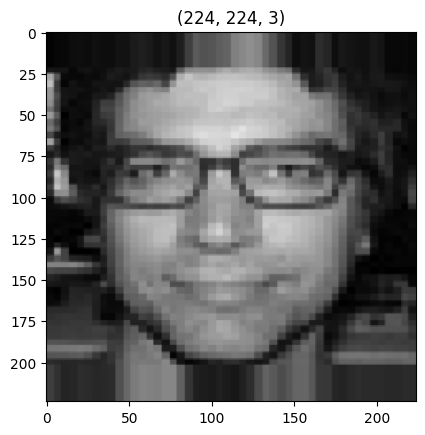

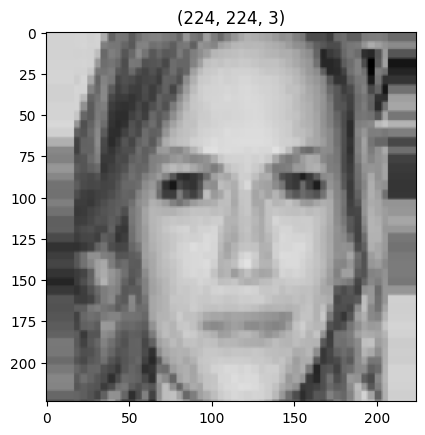

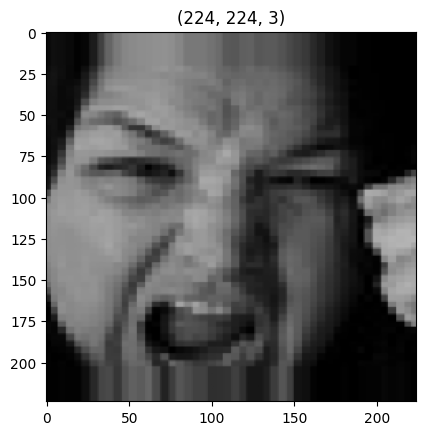

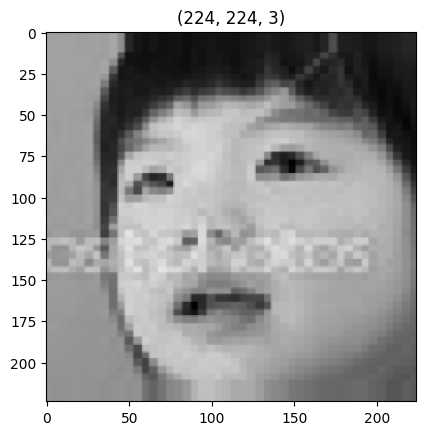

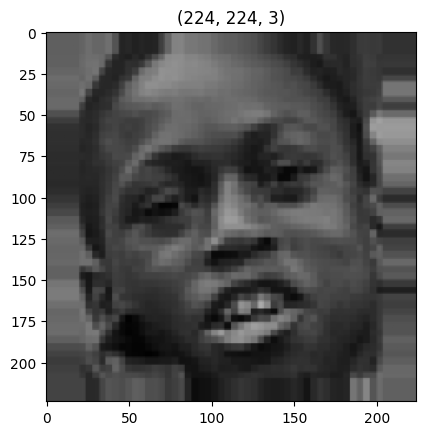

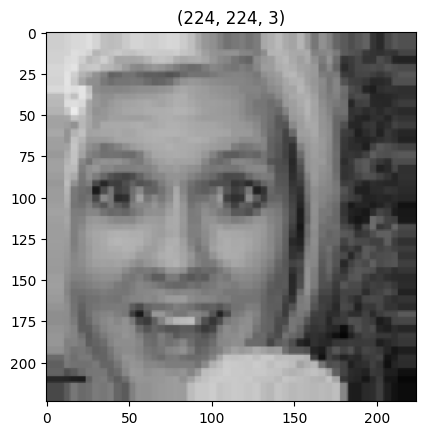

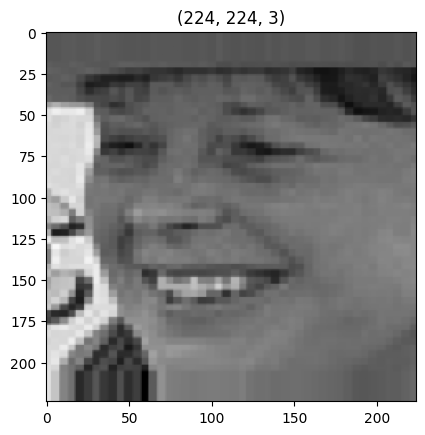

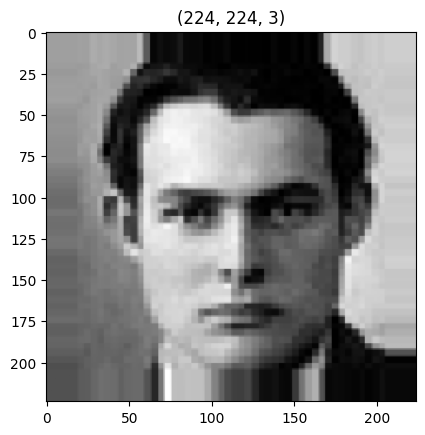

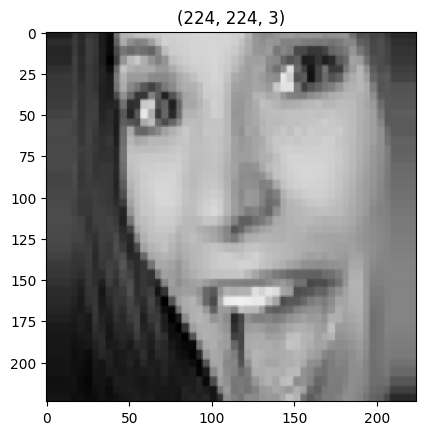

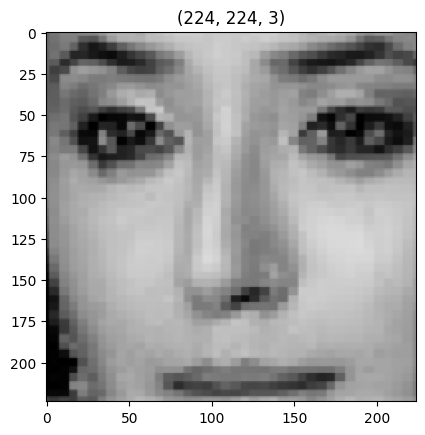

In [9]:
t_img , label = next(training)


def plotImages(img_arr, label):
  """
  input  :- images array
  output :- plots the images
  """
  count = 0
  for im, l in zip(img_arr,label) :
    mpltb.imshow(im)
    mpltb.title(im.shape)
    mpltb.axis = False
    mpltb.show()

    count += 1
    if count == 10:
      break


plotImages(t_img, label)

# Now early stopping is here, to main reduce overfitting(Overfitting happens when a model learns the detail and noise in the training data to the extent that it negatively impacts the performance of the model on new data.) and model check point

In [9]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler


early_stopping = EarlyStopping(monitor='val_accuracy', min_delta= 0.01 , patience= 10, verbose= 1, mode='auto')


model_checkpoint = ModelCheckpoint(filepath="best_model.keras", monitor= 'val_accuracy', verbose= 1, save_best_only= True, mode = 'auto')
def step_decay_schedule(epoch, lr):
    initial_lr = 0.001  # Starting learning rate
    drop_rate = 0.5     # Drop factor
    epochs_drop = 10    # Drop learning rate every 10 epochs
    if epoch % epochs_drop == 0 and epoch != 0:
        return lr * drop_rate
    return lr

# Create the callback
lr_scheduler = LearningRateScheduler(step_decay_schedule)

call_back = [early_stopping,
             model_checkpoint,
             lr_scheduler
             ]

# I have used 30 epoch, you can change it by urself,basically epoch are set according to specific points till the accuracy covergance, if accuracy down at any epoch then we stop epoch till there.

In [23]:
history = mdl.fit(training,
                          #  steps_per_epoch= 10,
                           epochs= 100,
                           validation_data= data_validation,
                          #  validation_steps= 10,
                           callbacks=call_back)

Epoch 1/100
897/898 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4384 - loss: 2.0876
Epoch 1: val_accuracy did not improve from 0.57328
898/898 ━━━━━━━━━━━━━━━━━━━━ 57s 58ms/step - accuracy: 0.4385 - loss: 2.0862 - val_accuracy: 0.5702 - val_loss: 1.1428 - learning_rate: 1.0000e-04
Epoch 2/100
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.6152 - loss: 1.0266
Epoch 2: val_accuracy improved from 0.57328 to 0.58958, saving model to best_model.keras
898/898 ━━━━━━━━━━━━━━━━━━━━ 53s 59ms/step - accuracy: 0.6152 - loss: 1.0266 - val_accuracy: 0.5896 - val_loss: 1.1224 - learning_rate: 1.0000e-04
Epoch 3/100
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.7017 - loss: 0.8144
Epoch 3: val_accuracy improved from 0.58958 to 0.59682, saving model to best_model.keras
898/898 ━━━━━━━━━━━━━━━━━━━━ 63s 70ms/step - accuracy: 0.7017 - loss: 0.8144 - val_accuracy: 0.5968 - val_loss: 1.0870 - learning_rate: 1.0000e-04
Epoch 4/100
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 

make sure to download the model from current session to your local PC

In [24]:
from keras.models import load_model
mdl = load_model("best_model.keras")

In [25]:
mdl.evaluate(data_validation)

225/225 ━━━━━━━━━━━━━━━━━━━━ 12s 43ms/step - accuracy: 0.6268 - loss: 1.7398


[1.6894456148147583, 0.6329060792922974]

In [26]:
hist_key =  history.history
hist_key.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss', 'learning_rate'])

# Now plotting the accuracy curve

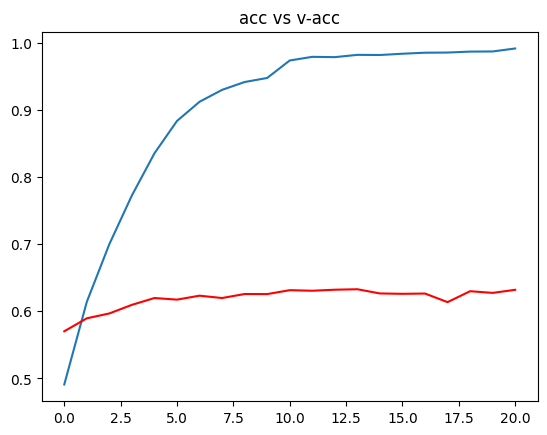

In [27]:
mpltb.plot(hist_key['accuracy'])
mpltb.plot(hist_key['val_accuracy'] , c = "red")
mpltb.title("acc vs v-acc")
mpltb.show()

# Now plotting the accuracy loss, loss is inversly proportional to accuracy, if loss decreases the accuracy increases, In this case loss decreases

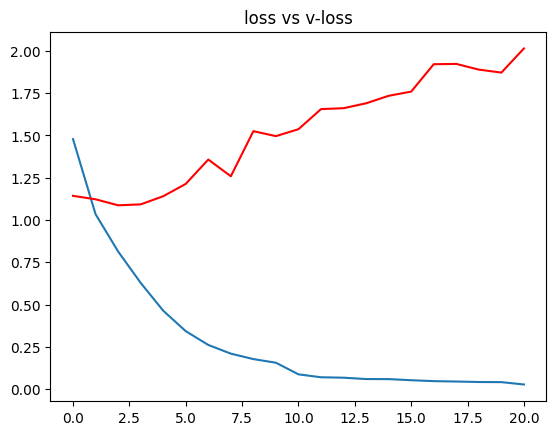

In [28]:
mpltb.plot(hist_key['loss'])
mpltb.plot(hist_key['val_loss'] , c = "red")
mpltb.title("loss vs v-loss")
mpltb.show()

In [ ]:
op = dict(zip( training.class_indices.values(), training.class_indices.keys()))

#Provide the path of the image or upload the image in order to detect real time emotion detection.
#insert path in "pway"

 the image is of Sad


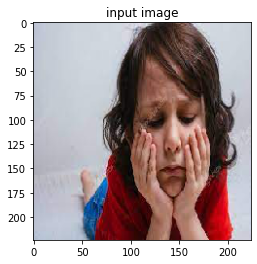

In [ ]:
pway = "/content/drive/MyDrive/expression_task/check_images/download--(39).jpg"
img = load_img(pway, target_size=(224,224) )

i = img_to_array(img)/255
input_arr = nmy.array([i])
input_arr.shape

pred = nmy.argmax(mdl.predict(input_arr))

print(f" the image is of {op[pred]}")

mpltb.imshow(input_arr[0])
mpltb.title("input image")
mpltb.show()

# Working Completed

#---End----

#Thank You